# 単回帰モデル
ここでは、架空のビールの売り上げと気温のデータを使って単回帰モデルの説明をする。

## ベイズ単回帰モデル

In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ビールと気温のデータに関する散布図は次のようになる。

In [4]:
beer_temp = pd.read_csv('../data/2-2-beer-sales.csv')

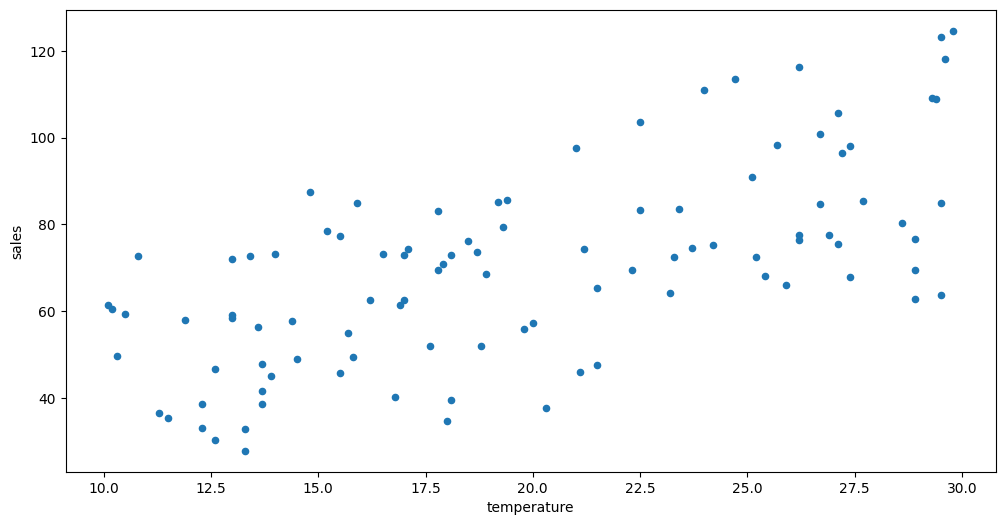

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
beer_temp.plot.scatter(x='temperature', y='sales', ax=axes)
plt.show()

個の図を見ると気温が上がるとビールの売り上げも上がるという線形の関係があるように思える。そこで、次のような単回帰モデルによってこの関係をモデル化する。
$$
\mu_i = w_0+w_1x_i\\
y_i \sim Normal(\mu_i, \sigma)
$$
ベクトル、行列形式で書くと次のようになる。
$$
\boldsymbol{\mu} = X\boldsymbol{w}^T \\
Y \sim Multivariate Normal(\boldsymbol{\mu}, \sigma I)
$$
ここで、$\boldsymbol{\mu}=(\mu_1, \cdots, \mu_n)^T$、$\boldsymbol{w}=(w_0, w_1)^T$で、$X$は各行が$(1, x_i)$となるデータ行列である。

## pymcでの実装

In [6]:
import pymc as pm

In [7]:
y = beer_temp['sales']
x = beer_temp['temperature']
with pm.Model() as model:
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    sigma = pm.HalfCauchy("sigma", beta=10)
    mu = pm.Deterministic("mu", w0 + w1 * x)
    y_data = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

モデルの構造は次のようになる。ここでは$\beta$の事前分布として平均0, 標準偏差20の正規分布を、$\sigma$の事前分布として半コーシー分布を利用した。

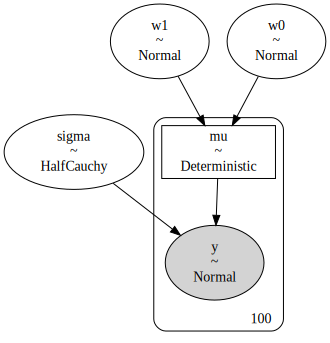

In [8]:
g = pm.model_to_graphviz(model)
display(g)

### MCMCの実行と収束の確認

In [9]:
with model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, sigma]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


r_hatが1.0なので全て収束しており、essが3000~4000なので、有効サンプル数は3000以上である。また、切片は19.529, 傾きは2.535であることがわかった。

In [10]:
summary = az.summary(trace, var_names=["w0", "w1", "sigma"])
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,19.515,5.656,8.456,29.558,0.096,0.069,3480.0,3706.0,1.0
w1,2.538,0.275,2.036,3.061,0.005,0.003,3478.0,3675.0,1.0
sigma,16.938,1.224,14.706,19.284,0.018,0.013,4474.0,4062.0,1.0


事後分布とトレースプロットを可視化すると次のようになり、視覚的にもMCMCが収束していることがわかる。

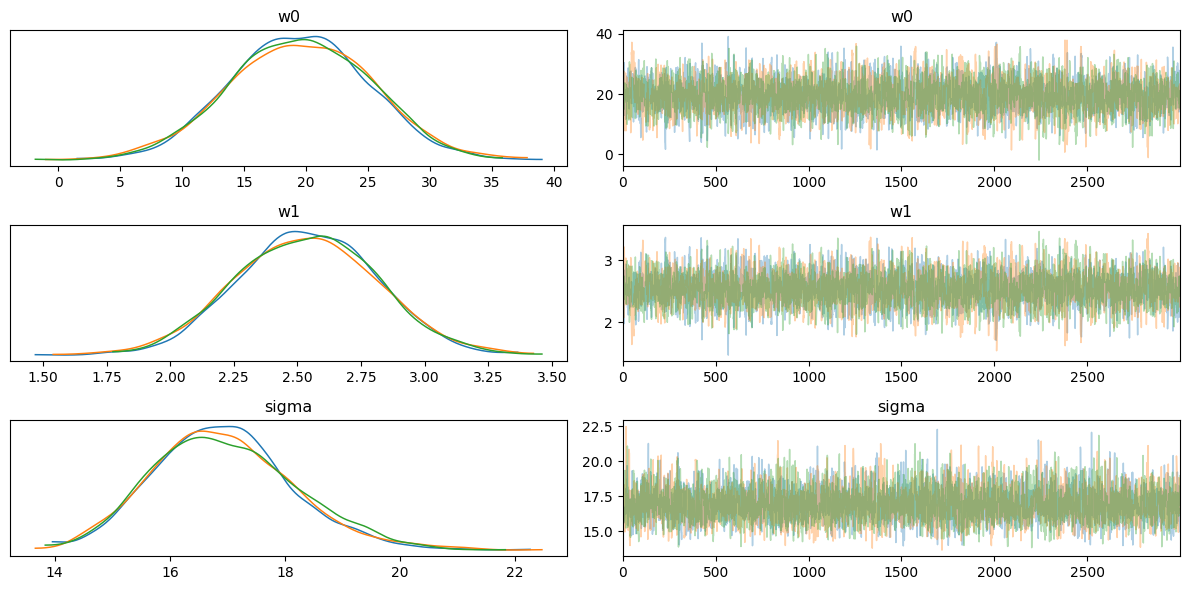

In [12]:
az.plot_trace(trace, var_names=["w0", "w1", "sigma"], compact=False)
plt.tight_layout()

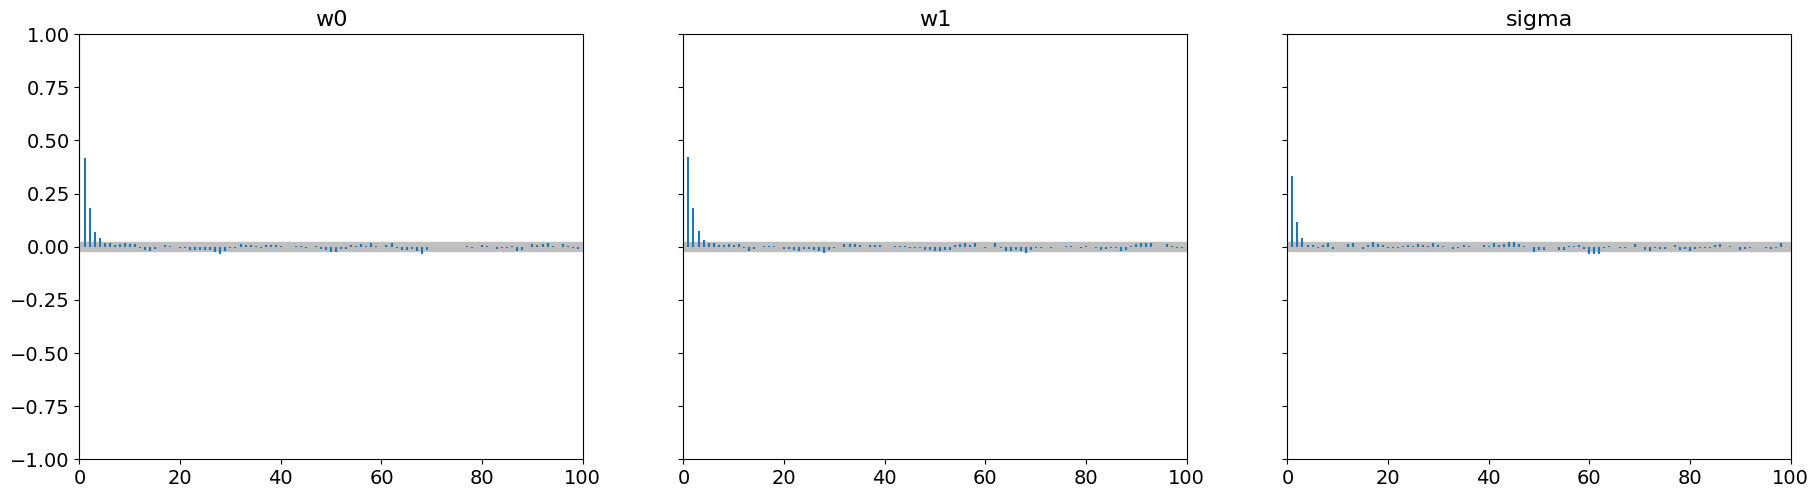

In [13]:
az.plot_autocorr(trace, var_names=["w0", "w1", "sigma"], combined=True)
plt.show()

事後分布は次のようになる。

これを見ると、切片と傾きのHDI(最高密度区間)が0を跨いでないことから、これらの値が0になる確率は小さく、有意に正の値を取るとできる。

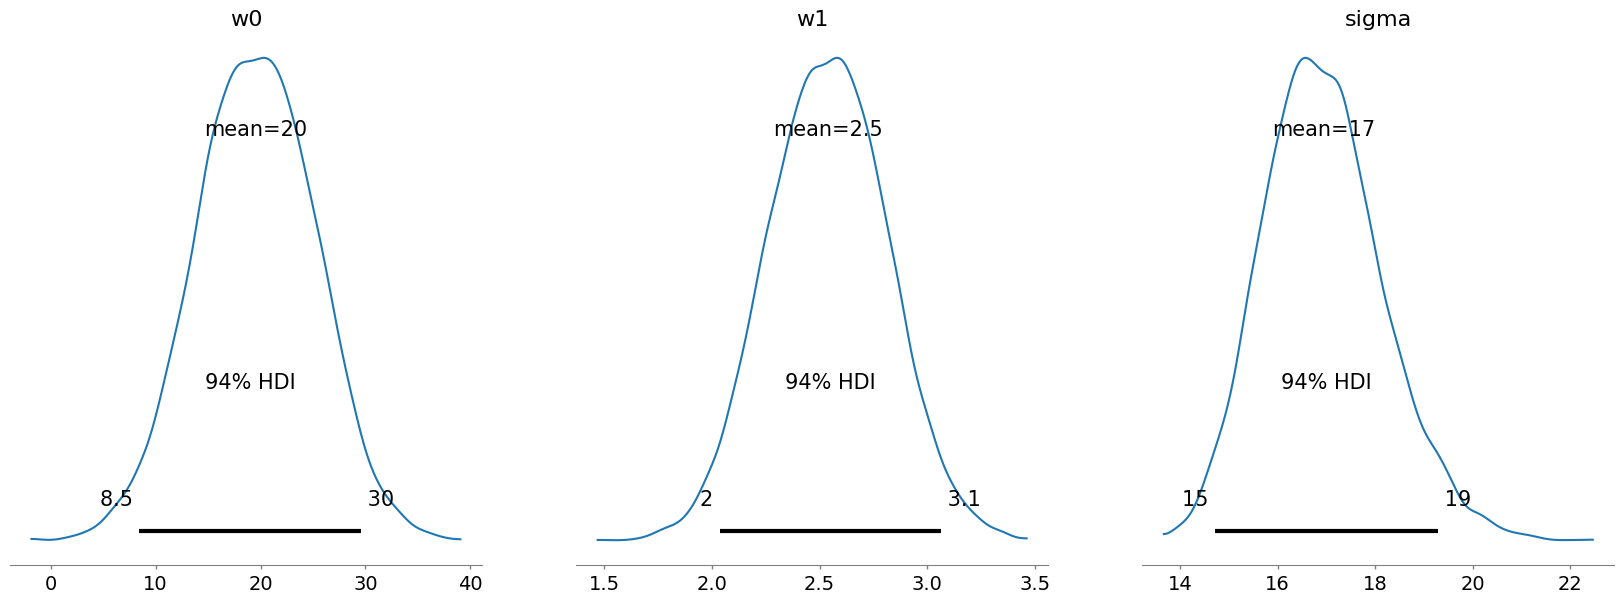

In [14]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(trace, var_names=["w0", "w1", "sigma"])

### 予測分布と信用区間の可視化
さて、パラメータの事後分布が得られたことから、これらに基づいた回帰直線と、$y$の予測分布$p(y|x)$を計算して、新たな$y$のサンプルが得られる。

まずはベイズ信用区間付き回帰直線を描く。次のようにMCMCサンプルから切片と傾きのサンプルを取り出し、各々回帰直線を描く。

In [15]:
# 回帰直線の範囲を指定(データの最小値-1, データの最大値+1)
x_values = np.array([x.min()-1, x.max()+1])
print(x_values, x_values.shape)

# MCMCのサンプルから、w0とw1のサンプルを3つおきに取り出す
w0_samples = trace['posterior']['w0'].values.reshape(-1, 1)[::3]
w1_samples = trace['posterior']['w1'].values.reshape(-1, 1)[::3]

# shapeの確認
print(w0_samples.shape, w1_samples.shape)

# 3000パターンそれぞれで、２点の１次関数値の計算
y_preds = w0_samples + x_values*w1_samples
print(y_preds.shape)

[ 9.1 30.8] (2,)
(3000, 1) (3000, 1)
(3000, 2)


さらに、切片と傾きの事後分布の平均から回帰直線を描く。

In [16]:
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
y_mean = w0_mean + x_values*w1_mean

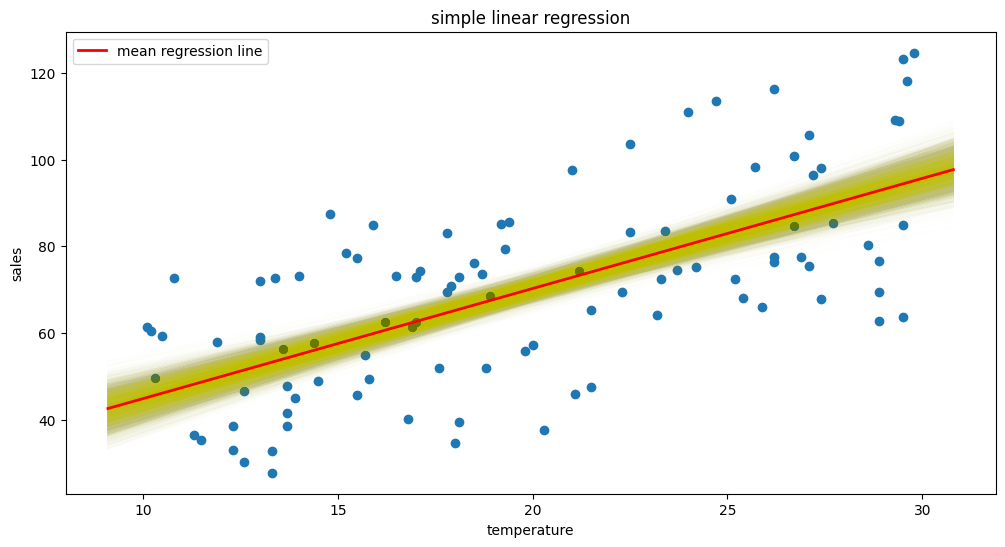

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
for y_pred in y_preds:
    axes.plot(x_values, y_pred, lw=1, alpha=0.01, c='y')
axes.plot(x_values, y_mean, lw=2, c='r', label='mean regression line')
axes.scatter(x, y)
plt.title('simple linear regression')
plt.xlabel('temperature')
plt.ylabel('sales')
plt.legend()
plt.show()

もしくは次のように$\mu$のHDIをプロットすることで描写することもできる。

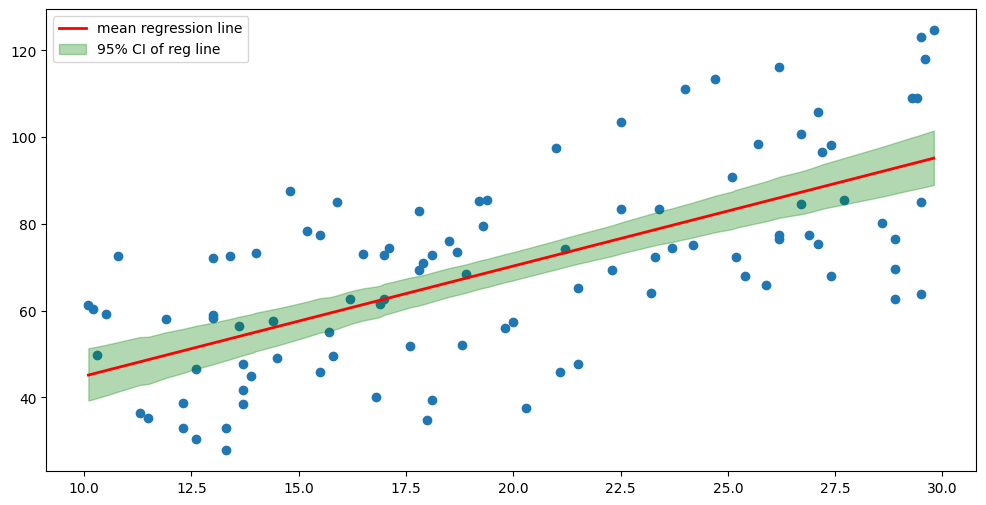

In [18]:
x_values = np.array([x.min(), x.max()])
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
y_mean = w0_mean + x_values*w1_mean

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
idx = np.argsort(x)
sig = az.hdi(trace.posterior, hdi_prob=0.95)["mu"].values[idx]  
axes.scatter(x, y)
axes.plot(x_values, y_mean, lw=2, c='r', label='mean regression line')
axes.fill_between(x[idx], y1=sig[:,0], y2=sig[:,1], color="g", alpha=0.30, label="95% CI of reg line")
plt.legend()
plt.show()

次に予測分布から新たなサンプルを得て、95%予測信用区間を描く。

In [19]:
# 予測値(y_pred)のサンプリング
myposterior = pm.sample_posterior_predictive(trace, model=model)

Sampling: [y]


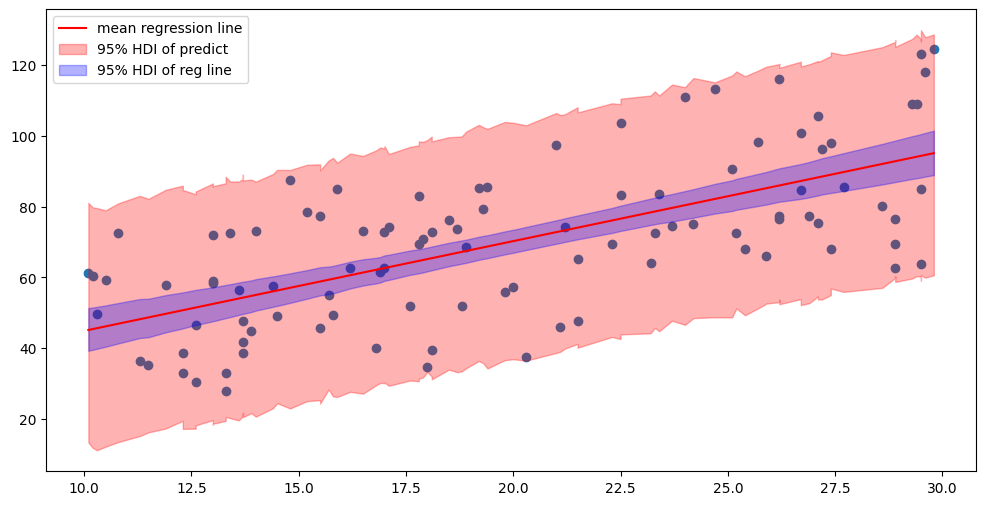

In [20]:
x_values = np.array([x.min(), x.max()])
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
y_mean = w0_mean + x_values*w1_mean

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sig_pred = az.hdi(myposterior.posterior_predictive, hdi_prob=0.95)["y"].values[idx]  # 予測分布の信頼区間
axes.scatter(x, y)
axes.plot(x_values, y_mean, lw=1.5, c='r', label='mean regression line')  # 事後分布の期待値による回帰直線
axes.fill_between(x[idx], y1=sig_pred[:,0], y2=sig_pred[:,1], color="r", alpha=0.3, label="95% HDI of predict")  # 予測分布のベイズ信用区間

sig_reg = az.hdi(trace.posterior, hdi_prob=0.95)["mu"].values[idx]  # muの事後分布の信頼区間
axes.fill_between(x[idx], y1=sig_reg[:,0], y2=sig_reg[:,1], color="b", alpha=0.30, label="95% HDI of reg line") # 事後分布のベイズ信用区間
plt.legend()
plt.show()

これを見ると、回帰直線の95%ベイズ信用区間よりも予測分布の95%信用区間の方が広い幅をとっている。これは、回帰直線の不確かさは回帰係数の不確かさのみで表されるのに対して、予測値の不確かさは回帰係数の不確かさに加えて、サンプリングの不確かさ$\sigma$が加わるため不確かさが大きくなるために起きる。

### モデルの詳細な定義
ここではモデルを次のように定義した。

In [21]:
y = beer_temp['sales']
x = beer_temp['temperature']
with pm.Model() as model:
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    sigma = pm.HalfCauchy("sigma", beta=10)
    mu = pm.Deterministic("mu", w0 + w1 * x)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y)

より詳細に次のように定義することができる

In [22]:
y = beer_temp['sales']
x = beer_temp['temperature']

model = pm.Model()
with model:
    # X, Yの観測値をConstantDataとして定義
    X_data = pm.ConstantData('X_data', x)
    Y_data = pm.ConstantData('Y_data', y)

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)

    # 平均値muの計算
    mu = pm.Deterministic("mu", w0 + w1 * X_data)

    #　誤差を示す確率変数sigmaの定義
    sigma = pm.HalfCauchy("sigma", beta=10)

    # 観測値が従う確立分布の定義
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=Y_data)

これはデータを観測値として詳細に定義している。

## pystanでの実装

In [23]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [24]:
beer_temp = pd.read_csv('../data/2-2-beer-sales.csv')

stanコードは次のようになる。ここでは、線形回帰についてtransformed parametersブロックで、$\mu$と$y$の事後分布についてgenerated quantitiesブロックで指定する。

In [39]:
stan_code = """
data {
    int N;                  // サンプルサイズ
    vector[N] sales;        // 売り上げデータ
    vector[N] temperature;  // 気温データ
  
    int new_N;              // 予測データのサンプルサイズ
    vector[new_N] new_temperature;  // 予測データの気温
}

parameters {
    real Intercept;         // 切片
    real beta;              // 係数
    real<lower=0> sigma;    // 標準偏差
}

transformed parameters {
    vector[N] mu;
    mu = Intercept + beta * temperature;
}

model {
    // 平均Intercept + beta*temperature
    // 標準偏差sigmaの正規分布に従ってデータが得られたと仮定
    sales ~ normal(Intercept + beta*temperature, sigma);
}

generated quantities {
    vector[new_N] yhat;
    vector[new_N] muhat;
    for (i in 1:new_N) {
        muhat[i] = Intercept + beta * new_temperature[i];
        yhat[i] = normal_rng(muhat[i], sigma);
    }
}
"""

In [41]:
new_temperature = np.linspace(beer_temp["temperature"].min(), beer_temp["temperature"].max(), 100)
new_N = len(new_temperature)
stan_data = {
    'N': len(beer_temp),
    'sales': beer_temp['sales'].values,
    'temperature': beer_temp['temperature'].values,
    "new_N": new_N,
    "new_temperature": new_temperature
}

In [28]:
with open("../stan/2-2-simple-linear-model.stan") as f:
    stan_code = f.read()

In [42]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/lgmrfq6i/model_lgmrfq6i.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 19.7s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [43]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,21.163,6.020,9.627,32.270,0.087,0.062,4794.0,5754.0,1.0
beta,2.460,0.290,1.903,2.998,0.004,0.003,4827.0,6115.0,1.0
sigma,17.068,1.247,14.704,19.341,0.016,0.011,5995.0,6601.0,1.0


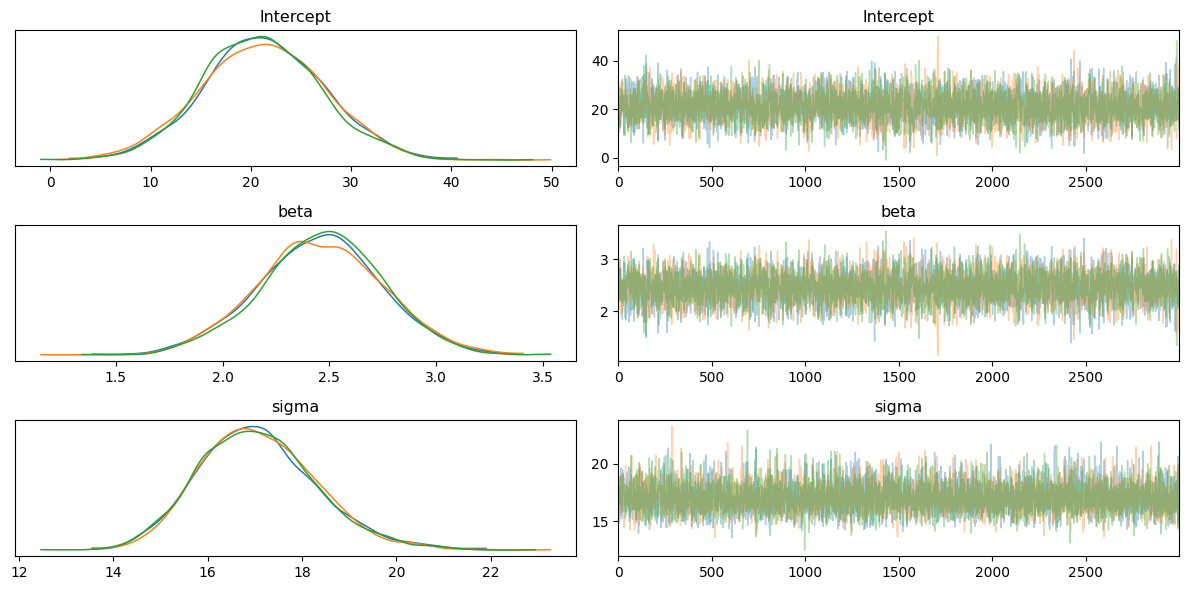

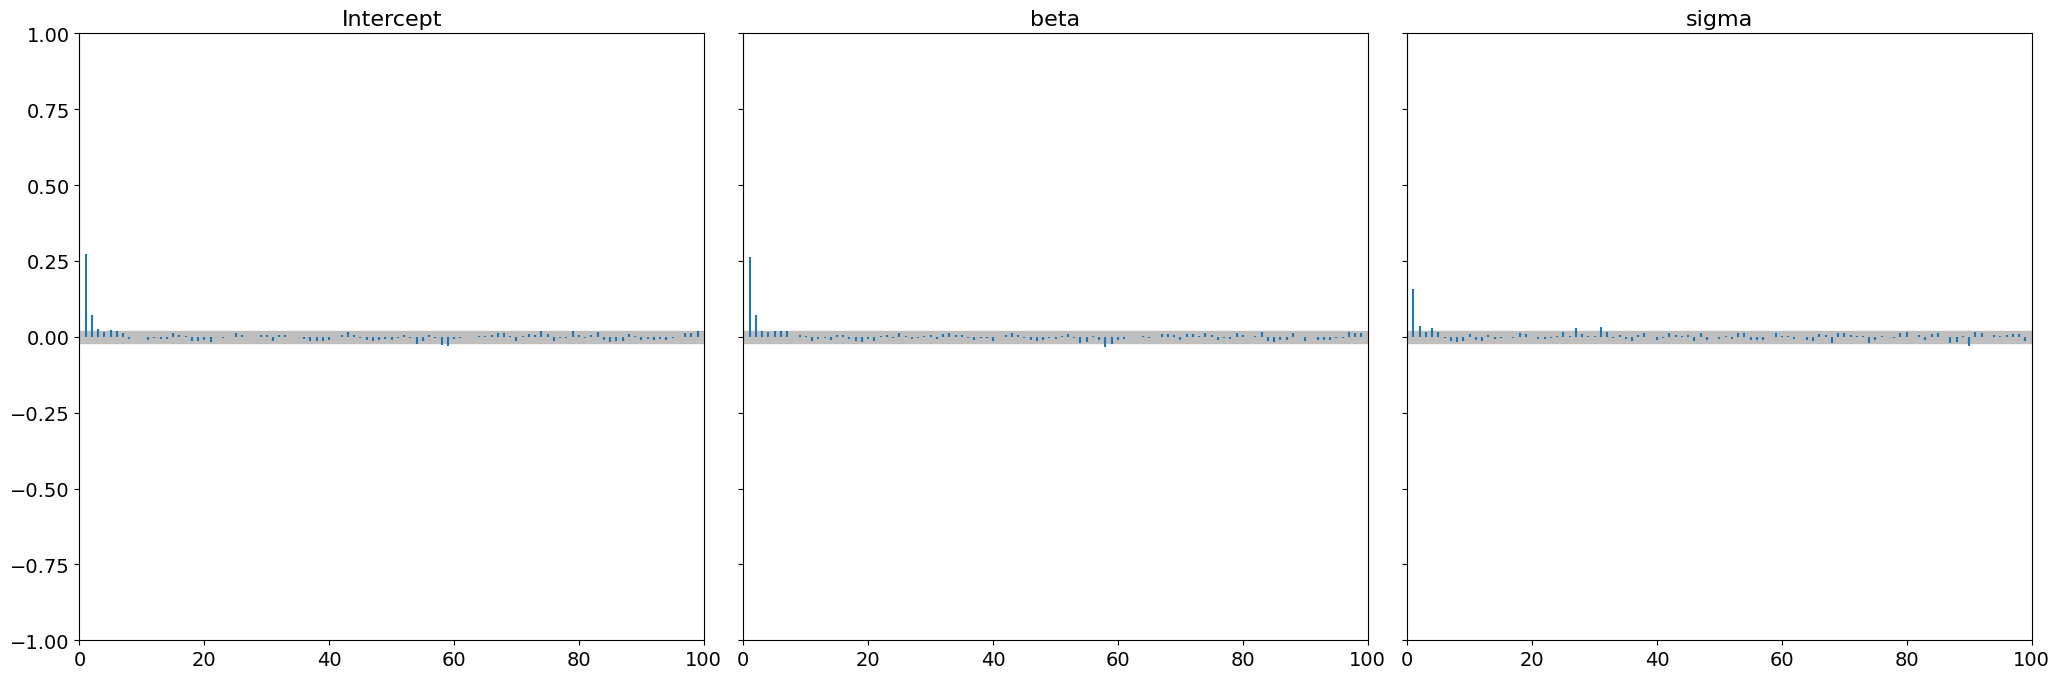

In [45]:
summary = az.summary(fit, var_names=["Intercept", "beta", "sigma"])
display(summary)
az.plot_trace(fit, var_names=["Intercept", "beta", "sigma"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["Intercept", "beta", "sigma"], combined=True)
plt.tight_layout()

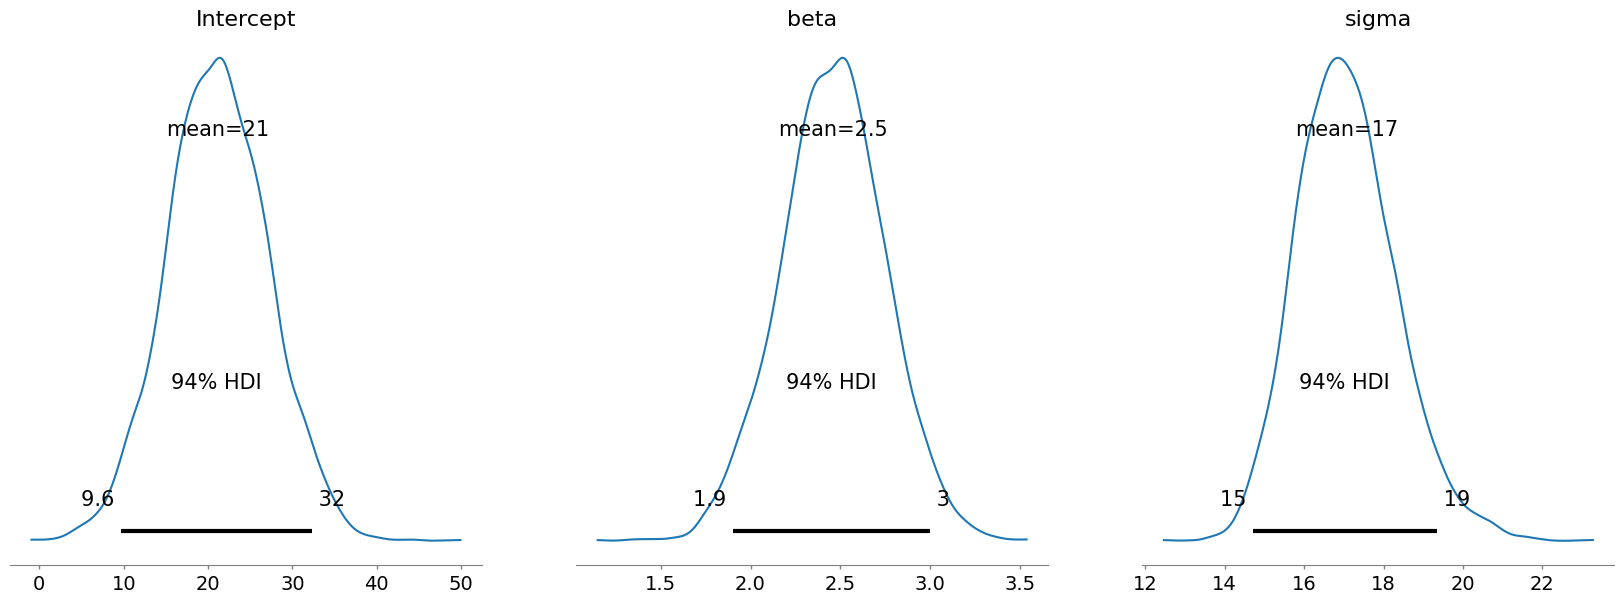

In [46]:
plt.rcParams['figure.figsize'] = (6, 6)
ax = az.plot_posterior(fit, var_names=["Intercept", "beta", "sigma"])

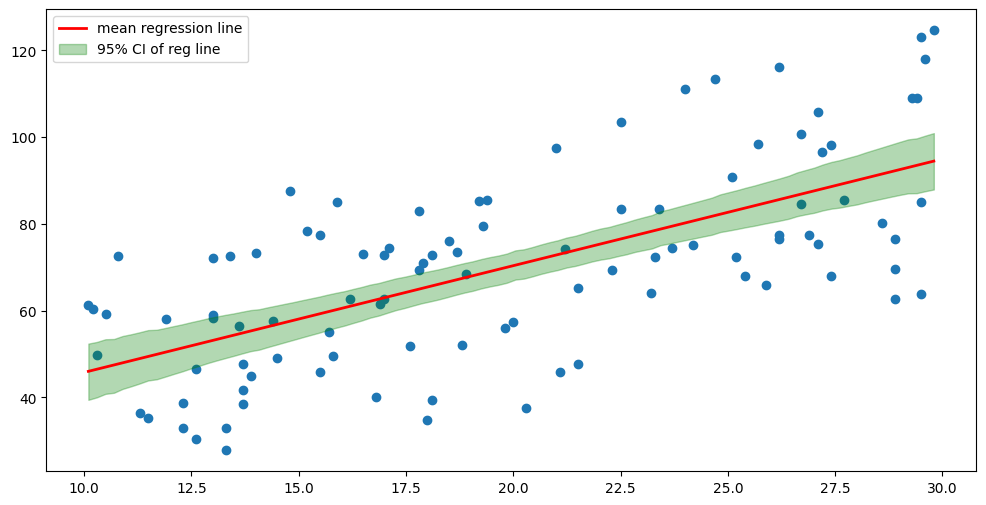

In [56]:
w0_mean = summary['mean'].Intercept
w1_mean = summary['mean'].beta
y_mean = w0_mean + new_temperature*w1_mean

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sig = az.hdi(fit, hdi_prob=0.95)["muhat"].values
axes.scatter(x, y)
axes.plot(new_temperature, y_mean, lw=2, c='r', label='mean regression line')
axes.fill_between(new_temperature, y1=sig[:,0], y2=sig[:,1], color="g", alpha=0.30, label="95% CI of reg line")
plt.legend()
plt.show()

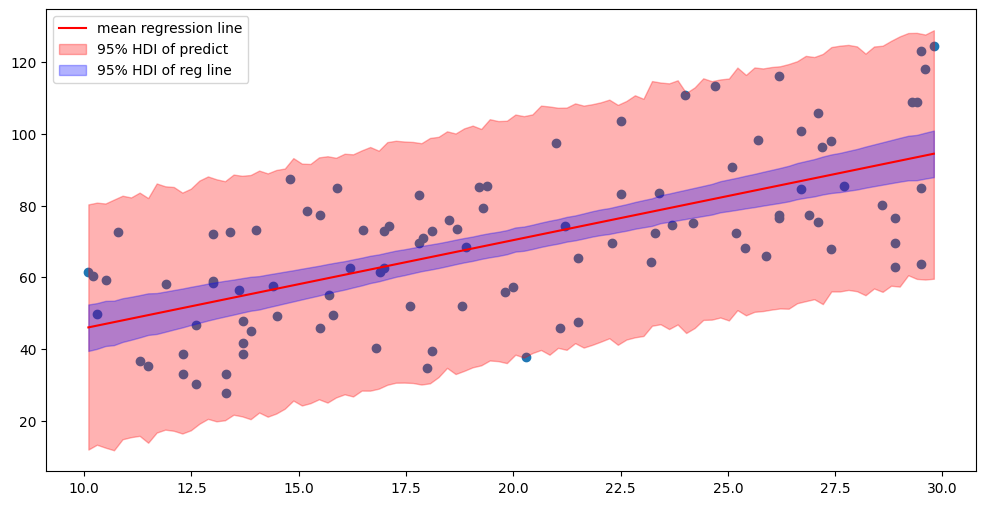

In [58]:
w0_mean = summary['mean'].Intercept
w1_mean = summary['mean'].beta
y_mean = w0_mean + new_temperature*w1_mean

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sig_mu = az.hdi(fit, hdi_prob=0.95)["muhat"].values # muの事後分布の信頼区間
sig_y = az.hdi(fit, hdi_prob=0.95)["yhat"].values  # 予測分布の信頼区間
axes.scatter(x, y)
axes.plot(new_temperature, y_mean, lw=1.5, c='r', label='mean regression line')  # 事後分布の期待値による回帰直線
axes.fill_between(new_temperature, y1=sig_y[:,0], y2=sig_y[:,1], color="r", alpha=0.30, label="95% HDI of predict")  # 予測分布のベイズ信用区間

axes.fill_between(new_temperature, y1=sig_mu[:,0], y2=sig_mu[:,1], color="b", alpha=0.30, label="95% HDI of reg line") # 事後分布のベイズ信用区間
plt.legend()
plt.show()